# Obesity Prediction with Random Forest Classifier

## 1. Import all the libraries required

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib  

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Load dataset and mapping the target

In [2]:
obesity = pd.read_csv("obesity.csv")

In [3]:
# change the target name from "NObeyesdad" to "target"
obesity.rename(columns={"NObeyesdad": "Target"}, inplace=True)

target_map = {
    "Insufficient_Weight": 0,
    "Normal_Weight": 1,
    "Overweight_Level_I": 2,
    "Overweight_Level_II": 3,
    "Obesity_Type_I": 4,
    "Obesity_Type_II": 5,
    "Obesity_Type_III": 6
}

obesity["Target"] = obesity["Target"].map(target_map)

## 3. Divide dataset into numerical and categorical

In [4]:
X = obesity.drop(columns=["Target"])
y = obesity["Target"]

# Divide features by type
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object', 'category']).columns

## 5. Train test and split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

## 6. Create the preprocessing pipeline

In [6]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

## 7. Define random forest classifier and combine it with the preprocessing pipeline

In [7]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

## 8. Hyperparameter tunning 

In [8]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=2
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}


## 9. Evaluate the best model


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        54
           1       0.77      0.91      0.83        58
           2       0.87      0.79      0.83        58
           3       0.95      0.93      0.94        58
           4       0.97      0.97      0.97        70
           5       1.00      0.97      0.98        60
           6       0.98      0.98      0.98        65

    accuracy                           0.93       423
   macro avg       0.93      0.93      0.93       423
weighted avg       0.94      0.93      0.93       423

Accuracy: 0.9314420803782506


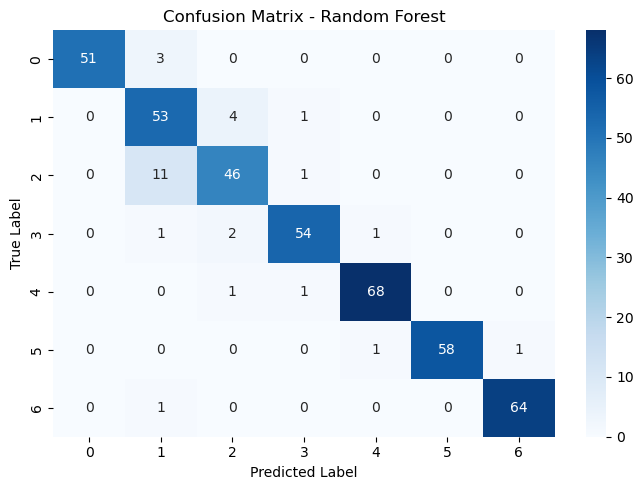

In [9]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Optional: Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## 10. Save the best model

In [10]:
joblib.dump(best_model, "random_forest_obesity.pkl")

['random_forest_obesity.pkl']

In [11]:
'''
# If you want to reload the model
model = joblib.load("random_forest_obesity.pkl")
pred = model.predict(new_data)
'''

'\n# If you want to reload the model\nmodel = joblib.load("random_forest_obesity.pkl")\npred = model.predict(new_data)\n'

## 11. Plot the ROC and AUC curve

In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------
# Prepare one-vs-rest setup
# ----------------------------------------------
n_classes = len(np.unique(y))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Get prediction probabilities
y_score = best_model.predict_proba(X_test)

# ----------------------------------------------
# Compute ROC curve and AUC for each class
# ----------------------------------------------
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

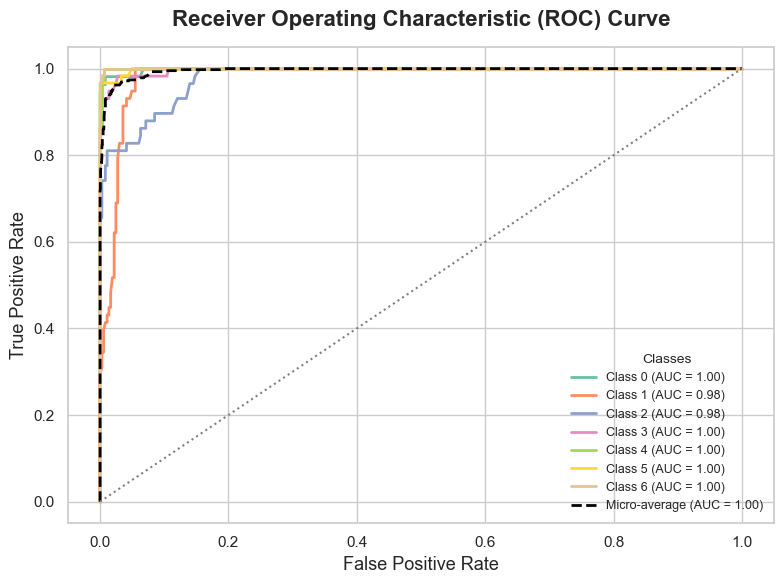

In [13]:
plt.figure(figsize=(8,6))
sns.set_theme(style="whitegrid")

colors = sns.color_palette("Set2", n_colors=n_classes)
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], tpr[i],
        color=color,
        lw=2,
        label=f"Class {i} (AUC = {roc_auc[i]:.2f})"
    )

# Micro-average line
plt.plot(
    fpr["micro"], tpr["micro"],
    color="black", linestyle="--",
    label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", lw=2
)

# Diagonal reference
plt.plot([0, 1], [0, 1], color="gray", lw=1.5, linestyle=":")

# Titles and labels
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.legend(title="Classes", fontsize=9, title_fontsize=10, loc="lower right", frameon=False)
plt.tight_layout()

# Save publication-grade version
plt.savefig("roc_auc_randomforest_publication.png", dpi=300, bbox_inches="tight")
plt.show()

## 12. SHapley Additive exPlanations (SHAP)

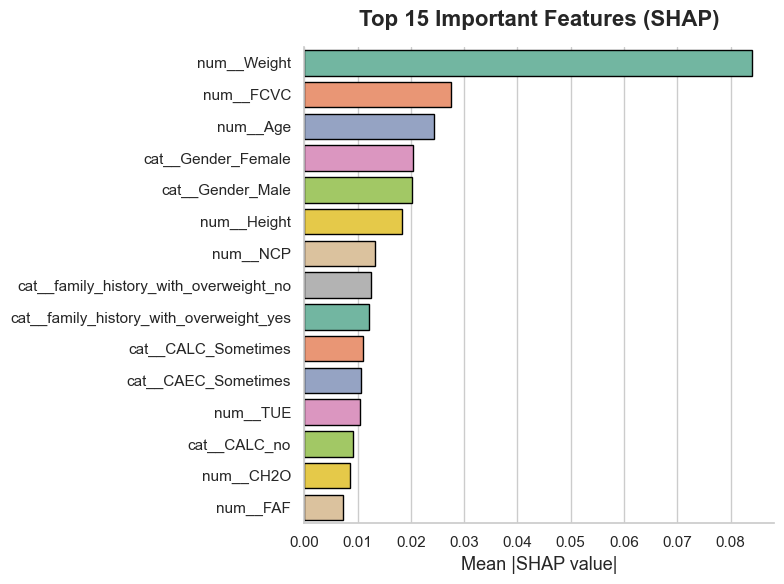

In [14]:
import shap

rf_model = best_model.named_steps["classifier"]
preprocessor = best_model.named_steps["preprocessor"]
X_preprocessed = preprocessor.transform(X_train)
feature_names = preprocessor.get_feature_names_out()

# Compute SHAP values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_preprocessed)

# Handle multi-class (list of arrays)
if isinstance(shap_values, list):
    # Average absolute SHAP values across classes - (n_samples, n_features)
    shap_values_mean_per_sample = np.mean([np.abs(sv) for sv in shap_values], axis=0)
else:
    shap_values_mean_per_sample = np.abs(shap_values)

# Take absolute values and average across samples and classes
mean_importance = np.mean(np.abs(shap_values), axis=(0, 2))  # (31,)

# Create summary DataFrame
shap_summary = (
    pd.DataFrame({
        "Feature": feature_names,
        "Importance": mean_importance
    })
    .sort_values("Importance", ascending=False)
)

# Plot publication grade SHAP summary
plt.figure(figsize=(8, 6))
sns.barplot(
    data=shap_summary.head(15),
    hue="Feature",  
    y="Feature", x="Importance",
    legend=False, 
    palette="Set2", edgecolor="black"
)
plt.title("Top 15 Important Features (SHAP)", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Mean |SHAP value|", fontsize=13)
plt.ylabel("")
sns.despine()
plt.tight_layout()
# Save publication-grade version
plt.savefig("SHAP_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()